In [13]:
import pandas as pd
import numpy as np
import random
import sys
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt


class Backtest:
    def __init__(self,price_data,strategy,initial_amount = 100000, has_tc = True, full_data = None):
        if self.check_input_data(price_data) == True:
            self.df = price_data
        else:
            return
        
        #k,v : String of ticker, a Position type instance
        self.positions = {}
        
        #cash
        self.cash = initial_amount
        
        #strategy
        self.strategy = strategy
        
        #have transaction cost or not 
        if has_tc == True:
            self.tc = 0.002
        else:
            self.tc = 0
        
        #round for backtest step
        self.current = 0
        
        #dfs to record
        self.transaction_history = pd.DataFrame(columns = ["dt","ticker","type","price","shares","amount","cash_left","transaction_cost","pnl"])
        self.portfolio_tracker = pd.DataFrame(columns = ["dt","bid_count","position_count","cash_value","positions_value","total_value","bah"])
        self.portfolio_tracker.loc[0] = [self.df.index[0],0,0,self.cash,0,self.cash,self.cash]
        
        #a dataframe contains predictions, used for model test
        if full_data != None:
            self.full_data = full_data
        else:
            self.full_data  = pd.DataFrame(index = self.df.index)

    
    def check_input_data(self,df):
        if df.index.inferred_type != "datetime64":
            print("input dataframe must have a datetime64 index")
            return False
        if df.isnull().values.any():
            print("input dataframe contains null values")
            return False
        return True


    def update_positions(self,ti):
        current_price = self.df.loc[ti]
        for position in list(self.positions.values()):
            position.price = current_price[position.ticker]
    

    
    def record_transaction(self,ti,bid,pnl):
        record = [ti,bid.ticker,bid.bid_type,bid.price,bid.shares,bid.price*bid.shares,self.cash,bid.price*bid.shares*self.tc,pnl]
        self.transaction_history.loc[len(self.transaction_history)] = record
        
    def update_tracker(self,ti,bid_list,positions,cash):
        rets = [end/start for start,end in zip(self.df.iloc[0].values,self.df.loc[ti].values)]
        bah_value = sum(([100000//len(self.df.columns)*ret for ret in rets]))
        positions_value = sum([pos.price*pos.shares for pos in self.positions.values()])
        record = [ti,len(bid_list),len(positions),cash,positions_value,positions_value+cash,bah_value]
        self.portfolio_tracker.loc[len(self.portfolio_tracker)] = record

    def clear_positions(self):
        bid_list = []
        for pos in self.positions.values():
            bid = Bid(ticker = pos.ticker,shares = pos.shares,price = self.df.iloc[-1][pos.ticker],bid_type = 0)
            bid_list.append(bid)
        self.process_bids(bid_list)

    def upload_to_dashboard(self,name):
        if len(self.portfolio_tracker) < len(self.df):
            print("Unable to upload: Backtest is unfinished.")
            return
        if "algo-trade-dashboard-80cae071e907.json" not in os.listdir():
            print("Unable to upload: Couldn't find credential file (algo-trade-dashboard-80cae071e907.json)")
            return
        
        
        self.portfolio_tracker.to_csv(name+"_backtest_result.csv")
        


        gauth = GoogleAuth()
        scope = ['https://www.googleapis.com/auth/drive.file',
            'https://www.googleapis.com/auth/drive',
            'https://www.googleapis.com/auth/drive.file',
            'https://www.googleapis.com/auth/drive.metadata'
          ]
        

        gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name("algo-trade-dashboard-80cae071e907.json", scope)
        drive = GoogleDrive(gauth)

        file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

        for file in file_list:
            id = file['id']
            if name+"_backtest_result.csv" == file['title']:
                f1 = drive.CreateFile({'name':name+"_backtest_result.csv",'id':id})
                f1.SetContentFile(name+"_backtest_result.csv")
                f1.Upload()
                print("Data uploaded.")
                return

        f1 = drive.CreateFile({'name':name+"_backtest_result.csv"})

        f1.SetContentFile(name+"_backtest_result.csv")
        f1.Upload()
        os.remove(name+"_backtest_result.csv")
        print("Data uploaded.")
    
    
    def process_bids(self,ti,bid_list):
        for bid in bid_list:
            #if already have a position
            if bid.ticker in self.positions.keys():
                pos = self.positions[bid.ticker]

                #if increase position
                if bid.bid_type == 1:
                    cost = bid.shares * bid.price
                    if self.cash < cost * (1+self.tc):
                        print("Not enough cash to build a position for "+bid.ticker)
                        continue

                    #update cash
                    self.cash -= cost * (1+self.tc)

                    #update position
                    pos.change_position(bid)
                    self.record_transaction(ti,bid,0)

                #if decrease position
                else:
                    income = bid.shares * bid.price

                    #update position,and get a cost
                    temp_cost = pos.change_position(bid)

                    #if successful
                    if temp_cost != 0:
                        #update cash
                        self.cash += income
                        self.cash -= income*self.tc
                        #calculate pnl
                        pnl = income-temp_cost
                        #record this transaction
                        self.record_transaction(ti,bid,pnl)
                    
                    
                    if pos.shares == 0:
                        del self.positions[bid.ticker]

            #if not have a position yet
            else:
                cost = bid.shares * bid.price
                if self.cash < cost * (1+self.tc):
                    print("Not enough cash to build a position for "+bid.ticker)
                    continue

                #update cash
                self.cash -= cost * (1+self.tc)

                #build position
                self.positions[bid.ticker] = Position(bid)

                #record this transaction
                self.record_transaction(ti,bid,0)

        self.update_tracker(ti,bid_list,self.positions,self.cash)
        
        
        
    def plot(self):
        plt.figure()
        plt.plot(self.portfolio_tracker['total_value'], label = 'random_strat')
        plt.plot(self.portfolio_tracker['bah'],label = 'bah')
        plt.legend()
        plt.show()
    
    def backtest_step(self):
        #current ti
        ti = self.df.index[self.current]
        
        self.update_positions(ti)
        bid_list = self.strategy.predict(ti,self.df.loc[:ti],self.positions,self.cash,self.full_data.loc[:ti])
        self.process_bids(bid_list = bid_list,ti = ti)
        self.current+=1
        
        
        
    def backtest_full(self):
        for ti in self.df.index:
            self.update_positions(ti)
            bid_list = self.strategy.predict(ti,self.df.loc[:ti],self.positions,self.cash,self.full_data.loc[:ti])
            self.process_bids(bid_list = bid_list,ti = ti)
        self.clear_positions()

class Bid:
    def __init__(self,ticker,price,shares,bid_type):
        self.ticker = ticker
        self.price = price
        self.shares = shares
        self.bid_type = bid_type
    
    def __del__(self):
        return

    def show(self):
        print("---------------")
        if self.bid_type == 1:
            print("Buying:")
        else:
            print("Selling")
        print("Ticker: {}".format(self.ticker))
        print("Shares: {}".format(self.shares))
        print("Price: {}".format(self.price))
        print("---------------")


class Position:
    def __init__(self,bid):
        self.ticker = bid.ticker
        self.shares = bid.shares
        self.price = bid.price
        
        #k，v: price, number of shares purchased at that price
        self.purchase_history = {}
        self.wa_cost_price = bid.price
        self.update_cost(bid)



    def change_position(self,bid):
        self.price = bid.price
        if bid.bid_type == 1:
            self.shares += bid.shares
            self.update_cost(bid)
            
        
        if bid.bid_type == 0:
            if self.shares < bid.shares:
                print("Try to sell {} shares, but only got {} shares.".format(bid.shares,self.shares))
                return 0

            self.shares -= bid.shares
            return self.update_cost(bid)
            


        
    def update_cost(self,bid):
        #buy
        if bid.bid_type == 1:
            #if have purchased at this price
            if bid.price in self.purchase_history.keys():
                self.purchase_history[bid.price] += bid.shares
            else:
                self.purchase_history[bid.price] = bid.shares
            self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
            
            
                
        #sell
        else:
            
            #if empty position
            if bid.shares == self.shares:
                #weighted average
                
                return self.wa_cost_price * self.shares
            else:
                shares_left = bid.shares
                temp_cost = 0
                for price in sorted(self.purchase_history.keys()):
                    if shares_left > self.purchase_history[price]:
                        shares_left -= self.purchase_history[price]
                        temp_cost += price * self.purchase_history[price]
                        del self.purchase_history[price]
                    else:
                        self.purchase_history[price] -= shares_left
                        temp_cost += price * shares_left
                self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
                return temp_cost
                   
  
    def show(self):
        print("Ticker: {}".format(self.ticker))
        print("Shares_held: {}".format(self.shares))
        print("Latest_price: {}".format(self.price))
        print("weighted_average_cost: {}".format(self.wa_cost_price))
        print("----------------")
        print("Purchasing History")
        print("Price\tShares")
        for item in self.purchase_history.items():
            print(str(item[0])+'\t'+str(item[1]))


In [14]:
class DemoStrategy:
    def predict(ti,df,positions,cash,full_data):
#         if ti.minute == 0 or ti.minute == 30:
#             print("================={}=================".format(ti))
        bid_list = []

        #buy
        if ti.hour == 9 and ti.minute == 30:
            for i in range(10):
                ticker = random.choice(df.columns)
                bid = Bid(ticker = ticker, shares = 100, price = df.iloc[-1][ticker],bid_type = 1)
                bid_list.append(bid)
                #bid.show()
            return bid_list

        #sell
        if ti.hour == 16 and ti.minute == 0:
            #for all current positions
            for pos in positions.values():
                bid = Bid(ticker = pos.ticker,shares = pos.shares,price = df.iloc[-1][pos.ticker],bid_type = 0)
                bid_list.append(bid)
                #bid.show()
            return bid_list
        return bid_list

In [17]:
data = pd.read_csv("test_data.csv",index_col=[0])
data.index = pd.to_datetime(data.index)
random_strat = Backtest(data.dropna(axis = 0),DemoStrategy)

In [18]:
random_strat.backtest_full()

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for v
Not enough cash to build a position for ba
Not enough cash to build a position for pfe
Not enough cash to build a position for nke


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for cmg


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for goog
Not enough cash to build a position for anet


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for amzn


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for fdx


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for anet
Not enough cash to build a position for v
Not enough cash to build a position for vz
Not enough cash to build a position for stz


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for gm


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for amzn
Not enough cash to build a position for algn


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for goog
Not enough cash to build a position for hd


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for mrk


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for amzn


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for goog


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for algn
Not enough cash to build a position for adbe
Not enough cash to build a position for pg
Not enough cash to build a position for stx
Not enough cash to build a position for ba
Not enough cash to build a position for anet
Not enough cash to build a position for celg


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares


Not enough cash to build a position for fisv
Not enough cash to build a position for jnj
Not enough cash to build a position for txn


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for now
Not enough cash to build a position for bsx


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

Not enough cash to build a position for ba
Not enough cash to build a position for mmm
Not enough cash to build a position for spy
Not enough cash to build a position for atvi


/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:296: RuntimeWarning: invalid value encountered in double_scalars
  self.wa_cost_price = sum([i*j for i,j in self.purchase_history.items()])/self.shares
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_60305/826493686.py:29

TypeError: process_bids() missing 1 required positional argument: 'bid_list'

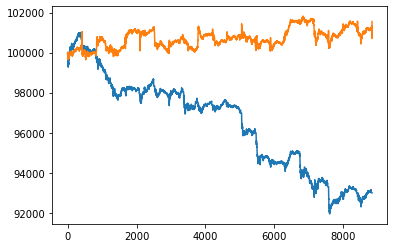

In [19]:
random_strat.plot()